In [87]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot
import os
import awkward as ak
from fast_histogram import histogram1d, histogram2d
import datetime
import pickle

# Converting calorimeter input to 2D histogram images

This script creates calorimeter images based on the calorimeter data from the ATLAS Open jet reconstruction data. 

In [88]:
MIN_RES = 20

rootfile = "/disk/atlas3/data_MC/ATLASOpen/jets/part1.root" 
RESOLUTION = 224#int(4*MIN_RES)
MAX_EVENTS = 1000

Using the with uproot loop, we can extract only the data we need and then close the original file. This will save us memory space.

In [89]:
#Load relevant data
with uproot.open(rootfile +":JetRecoTree") as file:
    events = file.arrays(library="ak", how="zip")
    print("Number of available events:", len(events))
    clusters = events["Clusters", ["pt", "eta", "phi", "m"]][:MAX_EVENTS]
    n_jets = ak.num(events["TruthJets_R10"])[:MAX_EVENTS]
    #clusters = clusters[ak.any(clusters.n_jets > 0, axis=1)]

Number of available events: 102900


We create the histograms by using the [fast-histogram library](https://pypi.org/project/fast-histogram/), which is 20-25 x faster than numpy.histogram2d. It does not support advanced binning however, so we perform a simple binning equal to the desired resolution of the image. 

In [90]:
#@nb.jit #could be optimized by using Numba, however 2d histogram is not straightforward to implement
def create_histograms(array):
    max_available_events = len(clusters)
    if max_available_events < MAX_EVENTS:
        max_events = max_available_events
    else: max_events = MAX_EVENTS
    first = datetime.datetime.now()
    Cal = [histogram2d(event.phi, event.eta, range=[[-np.pi, np.pi], [-2.5, 2.5]], bins=RESOLUTION, weights=event.pt) for event in array]
    second = datetime.datetime.now()
    print("Total time spent creating histograms: ", (second - first).total_seconds(), " seconds")
    return Cal
    
hists = create_histograms(clusters)

Total time spent creating histograms:  0.922076  seconds


Remember that python histograms produce images with input 2 (eta) on the x-axis and input 1 (phi) on the y-axis.

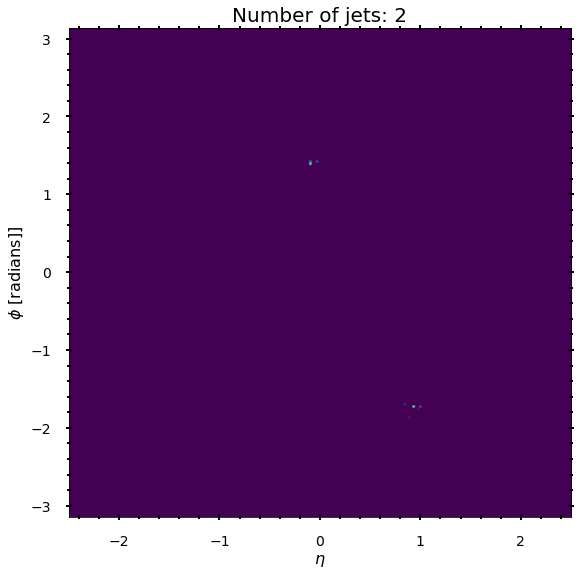

In [91]:
k = 49
def cal_image_plot(ax, n_jets):
    ax.set_ylabel(r"$\phi$ [radians]]", fontsize=16)
    ax.set_xlabel(r"$\eta$", fontsize=16)
    ax.set_title("Number of jets: " + str(n_jets), fontsize=20, color="black")
    ax.tick_params(which="both", direction="inout", top=True, right=True, labelsize=14, pad=15, length=4, width=2)
    ax.tick_params(which="major", length=8)
    ax.tick_params(which="major", length=6)
    ax.minorticks_on()

fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (9,9))
cal_image_plot(axs, n_jets = n_jets[k])
axs.imshow(hists[k], extent=[-2.5, 2.5, -np.pi, np.pi], aspect='auto')

In [92]:
#Save files as pickles
file_name = "jets_part1_" + str(MAX_EVENTS) + "events_" + str(RESOLUTION) + "x" + str(RESOLUTION) +"_min1jet" + ".pkl"
pickle.dump(hists, open("../data/histograms/" + file_name, 'wb'))
file_name = "jets_part1_" + str(MAX_EVENTS) + "events_" + str(RESOLUTION) + "x" + str(RESOLUTION) +"_min1jet_labels_njets" + ".pkl"
pickle.dump(n_jets, open("../data/histograms/" + file_name, 'wb'))